In [28]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(0,'./src')
from geometry import *
from solver import *
from some_weird_geometry import *
from time import perf_counter
import cProfile
import pstats
from pstats import SortKey

# constructing the geometry

In [29]:
G = circle(n=1024*8)
G.build()
v = np.zeros_like(G.x)
u = 1- G.y**2
U = np.array([u,v]).T

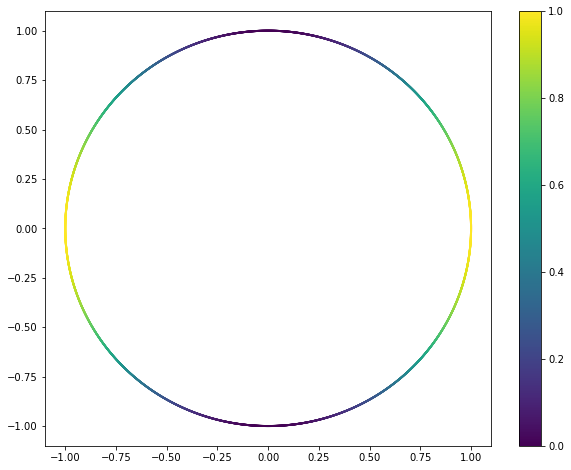

In [30]:
plt.figure(figsize=(10,8))
plt.scatter(G.x,G.y,s=1,c=u)
plt.colorbar()

In [31]:
solver = stokes2d(G)

In [32]:
with cProfile.Profile() as pr:
    omega_fmm = solver.compute_omega(U,if_fmm=True)

running gmres


KeyboardInterrupt: 

In [33]:
pstats.Stats(pr).strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()

         117474 function calls in 1174.043 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000 1174.043 1174.043 solver.py:55(compute_omega)
        1    0.000    0.000 1174.042 1174.042 <decorator-gen-5>:1(gmres)
        1    0.000    0.000 1174.042 1174.042 _threadsafety.py:42(caller)
        1    1.043    1.043 1174.042 1174.042 iterative.py:431(gmres)
     1659    0.011    0.000 1172.994    0.707 _interface.py:201(matvec)
      829    0.006    0.000 1172.979    1.415 _interface.py:529(_matvec)
      829    0.086    0.000 1172.973    1.415 solver.py:101(A_fmm)
     4141 1172.059    0.283 1172.128    0.283 fmm2d.py:720(cfmm2d)
      828    0.198    0.000  742.637    0.897 solver.py:146(K2_fmm)
      829    0.155    0.000  430.227    0.519 solver.py:122(K1_fmm)
     1658    0.006    0.000    0.294    0.000 geometry.py:88(get_data)
     1658    0.184    0.000    0.184    0.000 geometry.py:85(get_k)

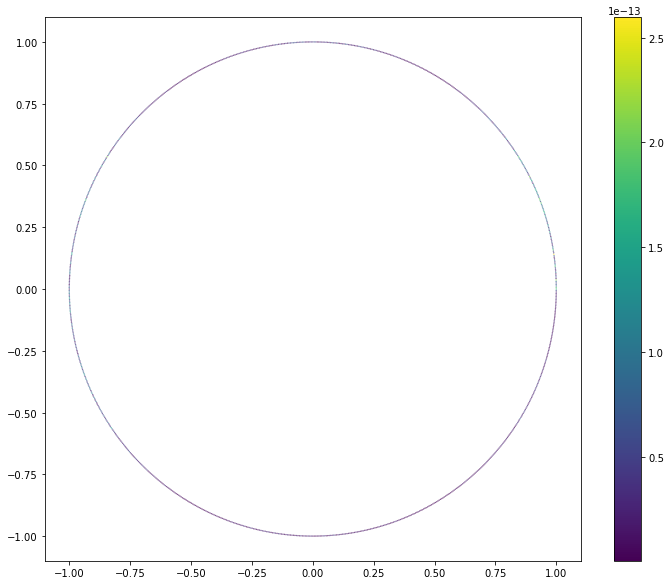

In [7]:
plt.figure(figsize=(12,10))
plt.scatter(G.x, G.y, c=np.abs(omega_exact - omega_fmm),s=0.1)
plt.colorbar()

# generating evaluation grid

In [5]:
x,y = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
z = x + 1j*y
z = z.flatten()
z = z[np.abs(z)<1]
x = np.real(z)
y = np.imag(z)

# velocity

In [6]:
s = perf_counter()
velocity_direct = solver.compute_velocity_direct(z,omega)
perf_counter() - s

0.18218129199999566

In [7]:
s = perf_counter()
velocity_fmm = solver.compute_velocity_fmm(z,omega)
perf_counter() - s

0.05199450000009165

In [8]:
np.max(np.linalg.norm(velocity_direct-velocity_fmm,axis=1)/np.linalg.norm(velocity_direct,axis=1))

1.7482883140952241e-12

# pressure

In [9]:
s = perf_counter()
pressure_direct = solver.compute_pressure_direct(z,omega)
perf_counter() - s

0.07550629200000003

In [10]:
s = perf_counter()
pressure_fmm = solver.compute_pressure_fmm(z,omega)
perf_counter() - s

0.015353250000089247

In [11]:
np.max(np.abs(1-pressure_fmm/pressure_direct))

2.0050627824730327e-13

In [12]:
1-np.max(np.abs(z))

0.0011740388417990077

# fmm formulars


## rfmm2d

$$
u(x) = \sum_{j=1}^{N} c_{j} * log(|x-x_{j}|) + d_{j}v_{j} \cdot \nabla( log(|x-x_{j}|) )
$$

## lfmm2d

$$
u(x) = \sum_{j=1}^{N} c_{j} * log(|x-x_{j}|) + d_{j}v_{j} \cdot \nabla( log(|x-x_{j}|) )
$$

## cfmm2d

$$
u(x) = \sum_{j=1}^{N} c_{j} * log(|x-x_{j}|) + d_{j}/(x-x_{j})
$$

## bhfmm2d

$$
u(x) = \sum_{j=1}^{N} c_{j} * \log(|x-x_{j}|) + 
          \overline{c}_{j} (x-x_{j})/(\overline{x-x_{j}}) + d_{j,1}/(x-x_{j}) - 
          d_{j,2}/(\overline{x-x_{j}}) - 
          \overline{d_{j,1}} (x-x_{j})/(\overline{x-x_{j}})^2
$$

- for cauchy-type integrals use the cfmm2d

In [13]:
K1, K2 = solver.build_kernels()

In [14]:
omega1 = np.random.uniform(0,1,size=omega.shape) + 1j*np.random.uniform(0,1,size=omega.shape)

In [15]:
def build_kernels(self):
    '''this builds the matrix for the Nystorm discretization'''
    
    # compute the kernels
    _, da, t, dt_da, k = self.geometry.get_data()
    dt = t[:, np.newaxis] - t[np.newaxis, :]
    d = dt_da[np.newaxis, :]
    da_ = da[np.newaxis, :]

    # this ignore the error for computing the diagonal elements with 0/0 error
    with np.errstate(divide='ignore', invalid='ignore'):
        K1 = -da_ * np.imag(d/dt) / np.pi
        K2 = -da_ * (-d/np.conjugate(dt) + np.conjugate(d)
                        * dt/(np.conjugate(dt**2))) / (2j*np.pi)
    # now we need to fill the diagonal elements
    d = dt_da
    K1_diagonal = k*np.abs(d)*da/(2*np.pi)
    K2_diagonal = -da*k*(d**2)/(np.abs(d)*2*np.pi)
    np.fill_diagonal(K1, K1_diagonal)
    np.fill_diagonal(K2, K2_diagonal)

    return K1,K2

In [16]:
def K2_fmm(geometry, omega):
        
    eps = 1e-17
    _, da, t, dt_da, k = geometry.get_data()
    sources = np.array([geometry.x,geometry.y])
    
    dt = dt_da*da
    
    K21 = fmm.cfmm2d(eps=eps,
                     sources=sources,
                     dipstr= - np.conjugate(dt*omega)/(2j*np.pi),
                     pg=1
                     ).pot.conjugate()
    
    K221 = t*fmm.cfmm2d(eps=eps,
                     sources=sources,
                     dipstr= - dt * omega.conjugate()/(2j*np.pi),
                     pg=2
                     ).grad.conjugate()
    
    K222 = fmm.cfmm2d(eps=eps,
                      sources=sources,
                      dipstr =   dt * omega.conjugate() * t.conjugate()/(2j*np.pi),
                      pg=2).grad.conjugate()
    
    # diagonal elements 
    K2_diagonal = -da*k*(dt_da**2)/(np.abs(dt_da)*2*np.pi) * omega
    
    return K21 + K221 + K222 + K2_diagonal

In [17]:
def K1_fmm(geometry, omega):
    
    
    eps = 1e-17
    _, da, t, dt_da, k = geometry.get_data()
    sources = np.array([geometry.x,geometry.y])
    charges = np.zeros_like(t)
    
    dt = dt_da*da
    
    K11 = fmm.cfmm2d(eps=eps,
                     sources=sources,
                     charges=charges,
                     dipstr= - dt*omega/(2j*np.pi),
                     pg=1
                     ).pot
    
    K12 = fmm.cfmm2d(eps=eps,
                     sources=sources,
                     charges=charges,
                     dipstr= - dt *omega.conjugate()/(2j*np.pi),
                     pg=1
                     ).pot.conjugate()
    
    # diagonal elements 
    d = dt_da
    K1_diagonal = k*np.abs(dt)*omega/(2*np.pi)

    return K11 + K12 +  K1_diagonal

In [18]:
def A_fmm(omega_sep,geometry=G):
    
    n = len(omega_sep)
    assert n%2 == 0
    n = n//2
    
    omega_real = omega_sep[:n]
    omega_imag = omega_sep[n:]

    omega = omega_real + 1j*omega_imag
    
    K1 = K1_fmm(geometry, omega)
    K2 = K2_fmm(geometry, omega.conj())
    
    ret = omega + K1 + K2
    ret_real = np.real(ret)
    ret_imag = np.imag(ret)
    
    return np.concatenate((ret_real,ret_imag))

In [19]:
from scipy.sparse.linalg import LinearOperator

In [20]:
n = len(G.get_t())
A = LinearOperator(dtype=np.float64, shape=(2*n,2*n), matvec=A_fmm)

In [21]:
from scipy.sparse.linalg import gmres

In [22]:
omega2_sep = gmres(A,np.concatenate([-v,u]),tol=1e-13)[0]

In [23]:
omega2 = omega2_sep[:n] + 1j*omega2_sep[n:]

In [24]:
np.max(np.abs(omega2 - omega))

2.597521532695144e-13